In [16]:
setwd("/Users/rebecca/sudmant/analyses/myotis/analysis/reciprocal_best_hits/contextualize_best_hits")

library(ggplot2)
library(data.table)

myo_meta <- read.csv("../../../data/myotis_meta.csv")

In [14]:
df <- fread("resources/mMyoAui_vs_mMyoCai_reciprocal_best_hits_peaks.tsv")

df$V7[grep("promoter", df$V7)] <- "Promoter"
df$V7[grep("TTS", df$V7)] <- "TTS"
df$V7[grep("intron", df$V7)] <- "Intron"
df$V7[grep("exon", df$V7)] <- "Exon"

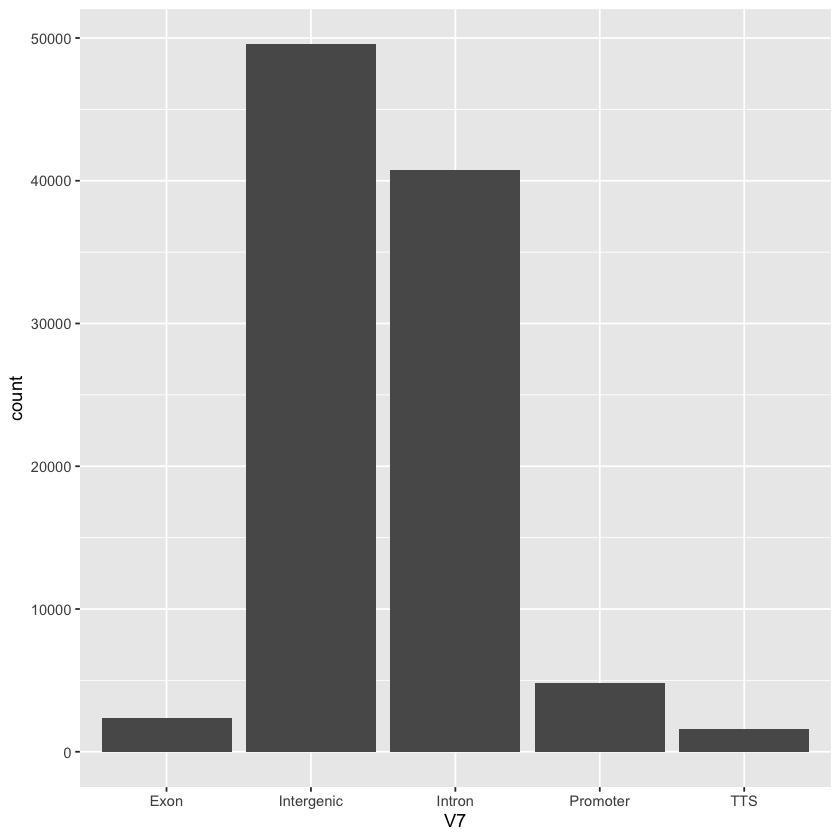

In [15]:
ggplot(df, aes(x = V7)) +
  geom_bar(stat = "count")

In [ ]:
for (i in seq_along(myo_meta$Abbr)) {
  for (j in seq_along(myo_meta$Abbr)) {
    if (i != j) {
      peaks1 <- fread(
        file.path("resources", list.files(path = "resources", pattern = paste0(myo_meta$Abbr[i], "_vs_", myo_meta$Abbr[j])))
      )
      peaks2 <- fread(
        file.path("resources", list.files(path = "resources", pattern = paste0(myo_meta$Abbr[j], "_vs_", myo_meta$Abbr[i])))
      )


    }
  }
}